In [4]:
from  matplotlib import pyplot as plt
%matplotlib inline

import json
import numpy as np
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import time

In [7]:
FOLDER_PATH = '/home/jim/Documents/data'
MAP_FN = 'motor_im_map.json'

In [ ]:
with open('/home/jim/Documents/data/motor_im_map.json', 'r') as f:
    map_data = json.loads(f.read())
print(map_data)

In [8]:
class MyDataset(Dataset):
    
    def __init__(self, folder_path, map_fn, transform=None, target_transform=None):
        self.folder_path = folder_path
            
        self.transform = transform
        self.target_transform = target_transform
        
        with open(f'{self.folder_path}/{map_fn}', 'r') as f:
            self.map_data = json.loads(f.read())
            self.keys = list(self.map_data.keys())

    def __getitem__(self, index):
        key = self.keys[index]
        label = self.map_data[key]
        img = Image.open(f'{self.folder_path}/img/{key}.jpg')
        
        if self.transform:
            img = self.transform(img)
            
        if self.target_transform:
            label = self.target_transform(label)

        return img, label

    def __len__(self):
        return len(self.map_data)
            

In [9]:
dataset = MyDataset(
    FOLDER_PATH,
    MAP_FN,
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    lambda label: torch.tensor(label) / 100
)

In [ ]:
print(len(dataset))
print(dataset[100][1])
print(dataset[1000][0].size())
print(dataset[1000][0])

In [10]:
batch_size = 8
shuffle_dataset = True

test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_dataset,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=shuffle_dataset,
    num_workers=4
)

In [12]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
print('feature type', train_features.dtype)
print('label type', train_labels.dtype)


Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: tensor([[ 0.0000,  0.0000],
        [-0.8000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.9000,  0.0500],
        [ 0.0000,  0.0000],
        [-1.0000, -0.0500],
        [-0.8000,  0.0000],
        [ 0.0000,  0.0000]])
feature type torch.float32
label type torch.float32


In [11]:
# model = models.alexnet(pretrained=True)
# model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)

device = torch.device('cuda')
model = model.to(device)

In [ ]:
# alexnet

NUM_EPOCHS = 30
BEST_MODEL_PATH = '/home/jim/Documents/model/my_model.pth'
best_accuracy = 0.0

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        print(outputs)
        print(labels)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    test_error_count = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))
    
    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    print('%d: %f' % (epoch, test_accuracy))
    
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_accuracy = test_accuracy

epoch: 1 ...
use time: 880.2453520298004, train loss: 0.11680951932974068, test loss: 0.0817241861322333
save model


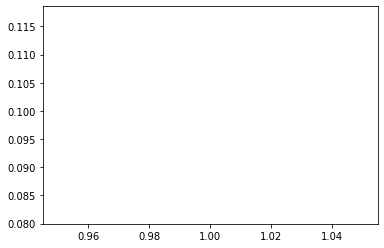

epoch: 2 ...
use time: 878.7464487552643, train loss: 0.09476439318269807, test loss: 0.07006184279268222
save model


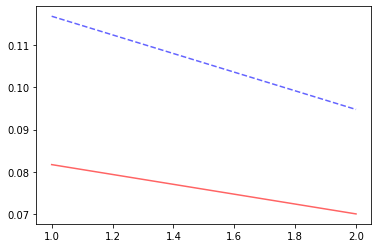

epoch: 3 ...
use time: 878.4184045791626, train loss: 0.07816449767619214, test loss: 0.06504748447517318
save model


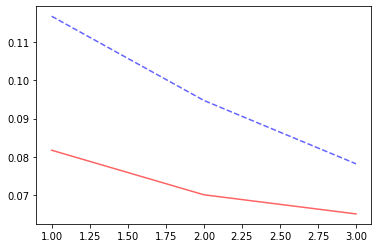

epoch: 4 ...
use time: 884.1269598007202, train loss: 0.06387977420132299, test loss: 0.06297076135755532
save model


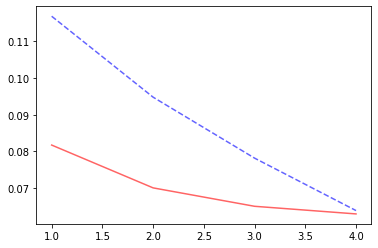

epoch: 5 ...
use time: 881.1556327342987, train loss: 0.05112183248115838, test loss: 0.06797468604608661


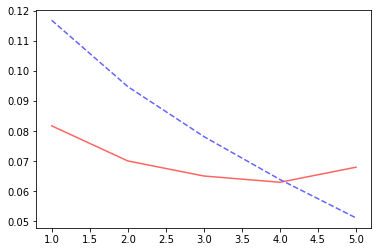

epoch: 6 ...
use time: 877.0656247138977, train loss: 0.04385099170328737, test loss: 0.048669314344546626
save model


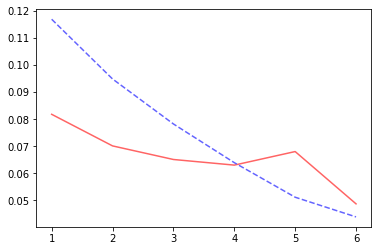

epoch: 7 ...
use time: 879.4480721950531, train loss: 0.03798788741113523, test loss: 0.060273618295064404


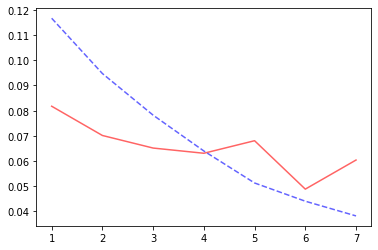

epoch: 8 ...
use time: 876.3400022983551, train loss: 0.03187088373242804, test loss: 0.0506304417633348


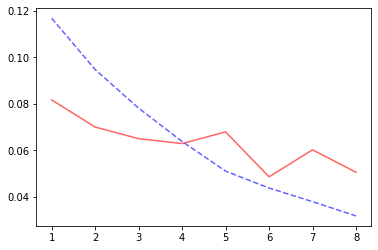

epoch: 9 ...


KeyboardInterrupt: 

In [15]:
# resnet18

NUM_EPOCHS = 70
BEST_MODEL_PATH = '/home/jim/Documents/model/best_steering_model.pth'
best_loss = 1e9

train_loss_history = []
test_loss_history = []

optimizer = optim.Adam(model.parameters())

for epoch in range(NUM_EPOCHS):
    print(f'epoch: {epoch + 1} ...') 
    _t = time.time()
    
    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
        
    test_loss /= len(test_loader)
    test_loss_history.append(test_loss)
    
    _dt = time.time() - _t
    print(f'use time: {_dt}, train loss: {train_loss}, test loss: {test_loss}')

    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
        print('save model')
        
    # plot
    x = range(1, len(train_loss_history) + 1)
    plt.plot(x, test_loss_history, color=(255/255,100/255,100/255))
    plt.plot(x, train_loss_history, '--', color=(100/255,100/255,255/255))
    plt.show()